# Creación y composición de arquitecturas de red

En este notebook vamos a ver cómo crear una arquitectura de red para resolver un problema determinado, entrenarla y validar su funcionamiento.

Los elementos necesarios para ello son los siguientes:

- Contenedores 
- Capas predefinidas
- Optimizadores
- Funciones de pérdida
- Definición de bucles de entrenamiento

Vamos a recordar los pasos básicos para entender un bucle de entrenamiento:

- Definir el modelo a entrenar
    - Definición de la arquitectura
    - De la pasada forward

- Definir el bucle de entrenamiento
    - Cargar un conjunto de datos, y dividirlo en:
        - Conjunto de entrenamiento
        - Conjunto de validación
    - Construcción del paso (step) de entrenamiento
        - Optimizador
        - Función de pérdida
    - Comprobación de la precisión del modelo


## Contenedores para la construcción de modelos en Pytorch

Vamos a empezar con el uso de contenedores en Pytorch para la construcción de modelos. En Pytorch, utilizamos *Modules* para la definición de arquitecturas de modelos de entrenamiento. Los *Modules* facilitan la construcción de modelos, la especificación de los parámetros que son aprendibles, la integración con el sistema de *Autograd* y la especificación del comportamiento de la pasada *Forward*.

Primero hacemos algunos imports, necesarios para los ejemplos de este notebook

In [5]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

Ahora vamos a hacer una definición del modelo con el contenedor *Module*. Este mecanismo requiere utilizar el constructor para definir la arquitectura del modelo, y una implementación específica para la pasada *Forward*. La arquitectura del modelo tiene:

- Una capa de aplanamiento (*flatten*)
- Una capa de tipo *Linear* (784 (28x28) -> 128)
- Una función de activación *ReLU*
- Otra capa de tipo *Linear* (128 -> 10)

In [3]:
# Definir la red neuronal como un módulo personalizado
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Definir las capas de la red
        self.flatten = nn.Flatten() # Capa de aplanamiento
        self.fc1 = nn.Linear(784, 128) # Capa completamente conectada
        self.relu = nn.ReLU() # Función de activación ReLU
        self.fc2 = nn.Linear(128, 10) # Capa completamente conectada para la salida

    def forward(self, x):
        # Definir el paso hacia adelante a través de la red
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

El modelo anterior tiene una arquitectura secuencial (lineal) y la pasada *Forward* consiste simplemente en conectar las salidas de una capa con las entradas de la siguiente capa. Este tipo de arquitectura es la más simple, pero también una de las más comunes, así que Pytorch proporciona un mecanismo simplificado para la definición de una arquitectura de este tipo (*nn.Sequential*) en el que no es necesario definir la pasada *Forward*. Veamos el ejemplo equivalente.

In [4]:
# Definir la arquitectura de la red utilizando Sequential
model = nn.Sequential(
    nn.Flatten(),  # Capa de aplanamiento
    nn.Linear(784, 128),  # Capa completamente conectada
    nn.ReLU(),  # Función de activación ReLU
    nn.Linear(128, 10)  # Capa completamente conectada para la salida
)

Aunque para un modelo simple, la inspección del código de su definición puede ser suficiente para visualizar la arquitectura del modelo. Existen varias soluciones para hacer una visualización del modelo más amigable. Vamos a ver un ejemplo de dos de ellas:
- torchsummary
- torchviz


In [8]:
!pip install torchsummary
from torchsummary import summary
#Visualizamos la arquitectura de la red
model.to('cuda')
summary(model, input_size=(1, 28, 28))

Defaulting to user installation because normal site-packages is not writeable
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                   [-1, 10]           1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.39
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


Defaulting to user installation because normal site-packages is not writeable


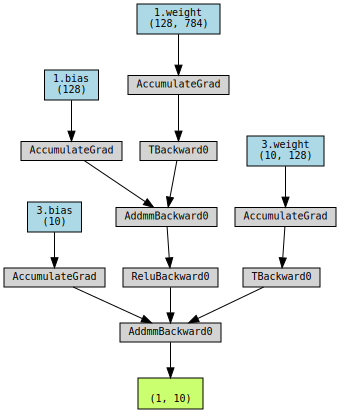

In [10]:
!pip install torchviz
import torchviz
from torch.autograd import Variable

model.to('cuda')
x = Variable(torch.randn(1, 1, 28, 28)).to('cuda')
torchviz.make_dot(model(x), params=dict(model.named_parameters()))

Los métodos *children* (*named_children*), *modules* (*named_modules*), y *parameters* (*named_parameters*) se pueden usar para recorrer los componentes de un módulo.

In [18]:
print("Named children =========")
for name, param in model.named_children():
    print(name, param)
print("Named modules =========")
for name, param in model.named_modules():
    print(name, param)
print("Named parameters =========")
for name, param in model.named_parameters():
    print(name, param)


Named children =========
0 Flatten(start_dim=1, end_dim=-1)
1 Linear(in_features=784, out_features=128, bias=True)
2 ReLU()
3 Linear(in_features=128, out_features=10, bias=True)
Named modules =========
 Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=10, bias=True)
)
0 Flatten(start_dim=1, end_dim=-1)
1 Linear(in_features=784, out_features=128, bias=True)
2 ReLU()
3 Linear(in_features=128, out_features=10, bias=True)
Named parameters =========
1.weight Parameter containing:
tensor([[-0.0279,  0.0238, -0.0267,  ..., -0.0285,  0.0003,  0.0143],
        [-0.0064,  0.0147,  0.0150,  ..., -0.0045,  0.0008,  0.0212],
        [-0.0321,  0.0037,  0.0028,  ..., -0.0171,  0.0297, -0.0306],
        ...,
        [-0.0061, -0.0194, -0.0299,  ...,  0.0120,  0.0292,  0.0327],
        [ 0.0201,  0.0049,  0.0256,  ...,  0.0232, -0.0117, -0.0318],
        [-0.0313, -0.0059, -0.0209, 

## Bucle de entrenamiento

Una vez definida la arquitectura del modelo, el siguiente paso consiste en la definición del buclee de entreamiento. Para ello, tenemos que asociar al modelo un optimizador. Pytorch implementa de forma nativa un gran número de algoritmos de optimización. El bucle de entrenamiento (step) consta de las siguientes etapas:
- Carga de la entrada
- Realización de la inferencia
- Cálculo de la función de pérdida (*loss function*)
- Reinicio de los gradientes de los parámetros
- Ejecución de la pasada *Backward* usando la función *backward()* asociada a la función  de pérdida para calcular los gradientes
- Ejecuión de la función *step()* asociada al optimizador para actualizar los gradientes

Vamos a ver ahora un ejemplo comentado de un modelo convolucional utilizado para entrenar el conjunto de datos MNIST. La definición de alguna de sus capas, y de otros elementos, es algo que todavía no hemos visto a estas alturas de la presentación, pero este código nos servirá para tener una visión general del problema.

In [19]:
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# Fijamos una semilla para que los resultados sean reproducibles
torch.manual_seed(42)

# Cargamos los datos: MNIST dataset
train_dataset = MNIST(root='./data', train=True, download=True, transform=ToTensor())
test_dataset = MNIST(root='./data', train=False, download=True, transform=ToTensor())

# Creamos los dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Definimos la función linear y relu en base a tensores
def linear(x, weight, bias):
    return torch.matmul(x, weight.t()) + bias

def relu(x):
    return torch.max(x, torch.zeros_like(x))

# Definición de la red neuronal
def simple_net(x):
    x = relu(linear(x, weight1, bias1))
    x = linear(x, weight2, bias2)
    return x

# Inicialización de los parámetros aleatoriamente
weight1 = torch.randn(128, 784, requires_grad=True)
bias1 = torch.randn(128, requires_grad=True)
weight2 = torch.randn(10, 128, requires_grad=True)
bias2 = torch.randn(10, requires_grad=True)

# Bucle de entrenamiento
epochs = 10
learning_rate = 0.01
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        # Flatten the images into a 1D tensor
        images = images.view(images.size(0), -1)

        # Zero the gradients
        weight1.grad = None
        bias1.grad = None
        weight2.grad = None
        bias2.grad = None

        # Forward pass
        outputs = simple_net(images)

        # Calculate loss
        loss = torch.nn.functional.cross_entropy(outputs, labels)

        # Backward pass
        loss.backward()

        # Update weights
        with torch.no_grad():
            weight1 -= learning_rate * weight1.grad
            bias1 -= learning_rate * bias1.grad
            weight2 -= learning_rate * weight2.grad
            bias2 -= learning_rate * bias2.grad

        # Track the loss
        running_loss += loss.item()

    # Print average loss for the epoch
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

# Evaluation on test set
correct = 0
total = 0
for images, labels in test_loader:
    images = images.view(images.size(0), -1)
    outputs = simple_net(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

# Print accuracy on the test set
print(f"Accuracy on test set: {100 * correct / total}%")


Epoch 1/10, Loss: 11.58234925946193
Epoch 2/10, Loss: 4.030419327493416
Epoch 3/10, Loss: 2.9322212804863446
Epoch 4/10, Loss: 2.3562217915871506
Epoch 5/10, Loss: 1.992010511283173
Epoch 6/10, Loss: 1.7221986807491592
Epoch 7/10, Loss: 1.526840920315813
Epoch 8/10, Loss: 1.36126474872716
Epoch 9/10, Loss: 1.2343973995093058
Epoch 10/10, Loss: 1.1274491242174782
Accuracy on test set: 88.66%


In [11]:
import torch
from torch import nn

# Hereda de nn.Module
class MyLinear(nn.Module):
  # Definición del modelo
  def __init__(self, in_features, out_features):
    super().__init__()
    self.weight = nn.Parameter(torch.randn(in_features, out_features))
    self.bias = nn.Parameter(torch.randn(out_features))
  # Definición de la operación forward
  def forward(self, input):
    return (input @ self.weight) + self.bias
  
m = MyLinear(4, 3)
sample_input = torch.randn(4)
m(sample_input)  

tensor([-2.1250,  4.4208,  1.2268], grad_fn=<AddBackward0>)

Epoch 1/10, Loss: 11.58234925946193
Epoch 2/10, Loss: 4.030419327493416
Epoch 3/10, Loss: 2.9322212804863446
Epoch 4/10, Loss: 2.3562217915871506
Epoch 5/10, Loss: 1.992010511283173
Epoch 6/10, Loss: 1.7221986807491592
Epoch 7/10, Loss: 1.526840920315813
Epoch 8/10, Loss: 1.36126474872716
Epoch 9/10, Loss: 1.2343973995093058
Epoch 10/10, Loss: 1.1274491242174782
Accuracy on test set: 88.66%


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Definición de la arquitectura del modelo
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
#Definición de la operación forward
    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = nn.functional.log_softmax(x, dim=1)
        return output

# Carga de los datos del dataset MNIST
train_dataset = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

test_dataset = datasets.MNIST('./data', train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
# Separación de los datos en batches, para entrenamiento y test
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Inicialización de la red y el optimizador
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# Definición de una función para entrenar el modelo
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.functional.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

# Definición de una función para validar el modelo
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.functional.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Bucle en el que se entrena el modelo y se evalúa durante 11 épocas
for epoch in range(1, 11):
    train(epoch)
    test()

/home/diegoandrade/.local/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307972
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.614601
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.545359
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.280141
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.473983
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.522550
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.177747
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.486807
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.209534
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.353559

Test set: Average loss: 0.1437, Accuracy: 9561/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.323789
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.397856
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.349941
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.145273
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.267328
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.217238
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.266196
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.200315
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.151066
T

En el ejemplo anterior, hemos usado varios elementos de Pytorch que sabemos que existen a nivel conceptual, pero para los que a estas alturas todavía no hemos visto los elementos del API que permiten su uso y definición. Algunos de ellos son:
- Tipos de capas predefinidos
- Optimizadores
- Funciones de pérdida

## Tipos de capas en Pytorch

Vamos a empezar por ver algunos ejemplos de funciones del API de Pytorch que permiten la definición de capas. Existen varias categorías de capas según su tipo:
- Lineales
- Convolucionales
- Pooling
- Padding
- Normalización
- Dropout
- Para redes recurrentes
- Para redes transformer

Empecemos con algún ejemplo ilustrativo de las capas lineales.

In [31]:
# Definimos una capa lineal simple
linear_layer = nn.Linear(3, 2)  # Tamaño entrada : 3, salida: 2
print("Weight matrix: ", linear_layer.weight)
print("Bias matrix: ", linear_layer.bias)

# Crear input data
input_data = torch.randn(4,3)
# Calcular la salida de la capa lineal
output_data = linear_layer(input_data)
output_data2 = input_data @ linear_layer.weight.t() + linear_layer.bias
# Imprimir los datos de entrada y salida
print("Input Data:")
print(input_data)
print("\nOutput Data:")
print(output_data)
print("\nOutput Data 2:")
print(output_data2)

Weight matrix:  Parameter containing:
tensor([[-0.0308, -0.4733, -0.0917],
        [ 0.3219, -0.1953,  0.2930]], requires_grad=True)
Bias matrix:  Parameter containing:
tensor([-0.3314, -0.2079], requires_grad=True)
Input Data:
tensor([[-0.3482, -0.9231,  0.6383],
        [ 1.8991,  0.3206,  1.5234],
        [ 0.2983, -0.5543,  0.6186],
        [ 0.2750,  1.6511, -0.6495]])

Output Data:
tensor([[ 0.0577,  0.0473],
        [-0.6813,  0.7870],
        [-0.1350,  0.1776],
        [-1.0618, -0.6322]], grad_fn=<AddmmBackward0>)

Output Data 2:
tensor([[ 0.0577,  0.0473],
        [-0.6813,  0.7870],
        [-0.1350,  0.1776],
        [-1.0618, -0.6322]], grad_fn=<AddBackward0>)


En muchos tipos de capas de Pytorch existe una versión *lazy* para la cual no es necesario proporciona la forma (*shape*) de la entrada. Veamos un ejemplo con *LazyLinear*

In [35]:
# Definimos una capa lineal simple (versión Lazy)
linear_layer = nn.LazyLinear(2)  # Tamaño entrada : desconocido, salida: 2
# Imprimimos los pesos y los bias antes de la primera llamada a la capa lineal
print("Weight matrix: ", linear_layer.weight)
print("Bias matrix: ", linear_layer.bias)

# Crear input data
input_data = torch.randn(4,3)
# Calcular la salida de la capa lineal
output_data = linear_layer(input_data)
output_data2 = input_data @ linear_layer.weight.t() + linear_layer.bias

# Imprimimos los pesos y los bias después de la primera llamada a la capa lineal
print("Weight matrix: ", linear_layer.weight)
print("Bias matrix: ", linear_layer.bias)

# Imprimir los datos de entrada y salida
print("Input Data:")
print(input_data)
print("\nOutput Data:")
print(output_data)
print("\nOutput Data 2:")
print(output_data2)

Weight matrix:  <UninitializedParameter>
Bias matrix:  <UninitializedParameter>
Weight matrix:  Parameter containing:
tensor([[-0.3125,  0.4832,  0.1145],
        [-0.4073,  0.2337, -0.4187]], requires_grad=True)
Bias matrix:  Parameter containing:
tensor([-0.1197,  0.4561], requires_grad=True)
Input Data:
tensor([[-0.1735,  0.1959,  2.2416],
        [ 1.7223,  0.4172,  1.0134],
        [ 0.4464,  0.2062,  0.8306],
        [ 1.6061,  0.4793, -1.5812]])

Output Data:
tensor([[ 0.2859, -0.3660],
        [-0.3403, -0.5721],
        [-0.0645, -0.0253],
        [-0.5711,  0.5761]], grad_fn=<AddmmBackward0>)

Output Data 2:
tensor([[ 0.2859, -0.3660],
        [-0.3403, -0.5721],
        [-0.0645, -0.0253],
        [-0.5711,  0.5761]], grad_fn=<AddBackward0>)


Las capas convolucionales están relacionadas con aplicaciones de procesamiento de señal, a menudo, imágenes y vídeo, y además de la familia de las capas convolucionales, tenemos también tipos de capas relacionados como son: Pooling, Padding, Normalización y Dropout. Vemos algunos ejemplos ilustrativos de estas capas.

In [42]:
import torch
import torch.nn as nn

# Creación de una capa Conv2D 
conv_layer = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)

# Crea algunos datos de entrada
# Tensor de entrada: (batch_size, nchannels, height, width)
input_data = torch.randn(1, 3, 32, 32)  

# Ejecuta la capa convolucional sobre los datos de entrada
output_data = conv_layer(input_data)

print("Forma de los datos y datos de entrada:")
print(input_data.shape)
print(input_data)
print("Capa convolucional (pesos y bias):")
print(conv_layer.weight)
print(conv_layer.bias)
print("\nForma de los datos y datos de salida:")
print(output_data.shape)


Forma de los datos y datos de entrada:
torch.Size([1, 3, 32, 32])
tensor([[[[ 2.2536,  1.4902, -0.3772,  ...,  0.3567,  1.3310, -1.2155],
          [ 0.2564,  0.1282,  0.4325,  ...,  0.6141, -0.2540, -1.3376],
          [-0.2065, -1.5369, -0.2166,  ..., -0.4992, -1.3978, -1.2252],
          ...,
          [ 0.4004,  1.2814,  1.0165,  ...,  1.3790, -0.1283,  0.1537],
          [-0.4196, -0.9416, -0.1998,  ..., -0.2781,  1.3424,  0.3440],
          [ 1.3564,  1.7729, -1.4882,  ..., -0.2471, -0.6083, -1.1830]],

         [[ 2.5222,  0.5607, -0.4229,  ..., -1.1158, -0.5386,  1.1211],
          [ 1.3293, -0.0855, -0.8541,  ...,  0.4937,  0.7172, -0.6303],
          [ 0.4190,  0.9188,  0.8026,  ...,  0.4096, -0.7371, -0.7299],
          ...,
          [-0.4155, -0.6191,  0.3465,  ...,  0.1378, -0.1317,  0.0272],
          [-0.0907, -0.1095, -1.1265,  ..., -1.1798, -0.5699, -1.4068],
          [ 0.9270, -1.8275, -3.3843,  ...,  0.0326, -0.4545, -1.6691]],

         [[-2.2827, -0.4983, -0.3818

A continuación, vamos a hacer algunas transformaciones y operaciones comunes sobre capas convolucionales. Para ello empezaremos con una capa e iremos aplicando todas esas operaciones.

In [6]:
import torch
import torch.nn as nn

torch.set_printoptions(precision=2)
# Creación de una capa Conv2D 
tensor=torch.randn(1,3,4,4)
print("Original tensor:")
print(tensor)
maxpooled2d=torch.nn.MaxPool2d(2, stride=2)
print("\nMaxPool2d:")
print(maxpooled2d(tensor))

Original tensor:
tensor([[[[ 1.15, -1.83,  0.25,  1.32],
          [-1.93, -0.09,  0.64, -2.10],
          [ 0.17, -1.73, -0.17,  0.71],
          [-0.27,  0.43,  0.33,  1.63]],

         [[ 1.59,  2.00,  0.27, -0.09],
          [-1.24, -0.79,  0.26,  0.19],
          [ 0.53, -0.16, -1.39, -1.27],
          [ 1.13, -1.13, -1.39,  0.96]],

         [[-0.07,  0.68,  0.12, -0.40],
          [-1.19, -1.09,  0.78,  1.02],
          [-0.83, -1.31, -0.06, -1.53],
          [ 0.99, -1.42, -0.78, -2.51]]]])

MaxPool2d:
tensor([[[[ 1.15,  1.32],
          [ 0.43,  1.63]],

         [[ 2.00,  0.27],
          [ 1.13,  0.96]],

         [[ 0.68,  1.02],
          [ 0.99, -0.06]]]])


In [7]:
import torch
import torch.nn as nn

torch.set_printoptions(precision=2)
# Creación de una capa Conv2D 
tensor=torch.randn(1,3,4,4)
print("Original tensor:")
print(tensor)
padding=torch.nn.ZeroPad2d(1)
print("\nZeroPadded:")
print(padding(tensor))

Original tensor:
tensor([[[[ 1.42, -0.07,  1.05, -0.53],
          [-0.53,  0.81,  0.39,  0.67],
          [ 0.52,  1.00, -1.14, -0.81],
          [-0.97, -0.12, -0.51, -1.80]],

         [[-0.20, -2.37,  0.29,  0.29],
          [ 1.13,  0.04, -0.88, -1.91],
          [-0.78, -0.12, -0.38, -1.08],
          [ 0.11, -0.48, -0.91, -1.97]],

         [[ 2.00, -1.18, -0.46,  0.51],
          [-0.24, -0.45,  0.19,  0.37],
          [ 0.83,  0.03, -0.80, -1.64],
          [ 0.70,  1.81,  1.19, -0.50]]]])

ZeroPadded:
tensor([[[[ 0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
          [ 0.00,  1.42, -0.07,  1.05, -0.53,  0.00],
          [ 0.00, -0.53,  0.81,  0.39,  0.67,  0.00],
          [ 0.00,  0.52,  1.00, -1.14, -0.81,  0.00],
          [ 0.00, -0.97, -0.12, -0.51, -1.80,  0.00],
          [ 0.00,  0.00,  0.00,  0.00,  0.00,  0.00]],

         [[ 0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
          [ 0.00, -0.20, -2.37,  0.29,  0.29,  0.00],
          [ 0.00,  1.13,  0.04, -0.88, -1.91,  0.

In [8]:
import torch
import torch.nn as nn

# Creación de una capa Conv2D 
torch.set_printoptions(precision=2)
tensor=torch.randn(1,3,4,4)
print("Original tensor:")
print(tensor)
normalization=torch.nn.BatchNorm2d(3)
print("\nNormalized:")
print(normalization(tensor))

Original tensor:
tensor([[[[-1.39,  1.09,  0.48, -1.50],
          [-1.80, -0.42, -0.44,  1.92],
          [-1.22, -0.64, -0.81, -2.22],
          [ 1.16, -0.51,  1.68, -0.84]],

         [[-2.44, -0.05,  0.04, -0.79],
          [-0.51, -1.95,  0.54, -0.50],
          [ 0.84,  0.38, -2.00, -0.90],
          [ 0.03,  0.50, -0.58,  0.82]],

         [[ 0.40, -0.17, -2.18, -0.24],
          [ 1.63,  0.79,  0.52,  1.82],
          [-0.06, -0.60,  0.96, -0.58],
          [-1.39,  0.30, -0.48, -0.78]]]])

Normalized:
tensor([[[[-0.86,  1.18,  0.67, -0.95],
          [-1.20, -0.06, -0.08,  1.86],
          [-0.73, -0.25, -0.38, -1.54],
          [ 1.24, -0.14,  1.66, -0.41]],

         [[-2.07,  0.37,  0.46, -0.39],
          [-0.10, -1.57,  0.97, -0.09],
          [ 1.27,  0.81, -1.62, -0.50],
          [ 0.45,  0.92, -0.17,  1.25]],

         [[ 0.40, -0.16, -2.15, -0.23],
          [ 1.62,  0.78,  0.52,  1.80],
          [-0.05, -0.59,  0.95, -0.57],
          [-1.37,  0.30, -0.47, -0.77]]

In [9]:
import torch
import torch.nn as nn

# Creación de una capa Conv2D 
torch.set_printoptions(precision=2)
tensor=torch.randn(1,3,4,4)
print("Original tensor:")
print(tensor)
dropout=torch.nn.Dropout2d(0.5)
print("\nDroppedout:")
print(dropout(tensor))

Original tensor:
tensor([[[[ 0.04,  0.97,  0.79, -1.50],
          [-1.00,  0.36,  0.96, -1.34],
          [-0.43,  0.01,  0.76,  0.90],
          [-0.08,  0.49, -0.62,  0.23]],

         [[ 0.70, -0.64, -0.20,  0.51],
          [-0.10, -0.58,  0.84,  0.41],
          [ 0.41,  1.31,  0.28,  1.23],
          [-1.67,  0.42, -1.62,  1.19]],

         [[ 0.83, -1.10, -0.54,  0.38],
          [-2.21, -0.35,  1.04,  0.59],
          [-0.06,  0.65, -0.09, -0.90],
          [ 0.76,  0.61, -1.43,  1.07]]]])

Droppedout:
tensor([[[[ 0.07,  1.95,  1.57, -3.00],
          [-1.99,  0.71,  1.92, -2.68],
          [-0.86,  0.03,  1.52,  1.80],
          [-0.15,  0.99, -1.23,  0.45]],

         [[ 0.00, -0.00, -0.00,  0.00],
          [-0.00, -0.00,  0.00,  0.00],
          [ 0.00,  0.00,  0.00,  0.00],
          [-0.00,  0.00, -0.00,  0.00]],

         [[ 0.00, -0.00, -0.00,  0.00],
          [-0.00, -0.00,  0.00,  0.00],
          [-0.00,  0.00, -0.00, -0.00],
          [ 0.00,  0.00, -0.00,  0.00]]

# Ejercicio

Observa el siguiente código en el que creamos una red convolucional para clasificar imágenes del dataset CIFAR-10. En el código faltan la definición de la arquitectura del modelo, debería ser hecha a base de capas *Linear* y *Conv2D* y la definición de la pasadad Forward. Completa esta información

[1] CIFAR-10 dataset: https://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# Creación de un transformador que normaliza los datos
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Descarga del dataset CIFAR-10: conjunto de entrenamiento
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# Creación de un dataloader para el dataset CIFAR-10: conjunto de entrenamiento
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
# Descarga del dataset CIFAR-10: conjunto de test
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
# Creación de un dataloader para el dataset CIFAR-10: conjunto de test
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)
# Definimos las clases del dataset CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')


# Crear un modelo de red neuronal
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Aquí debes definir las capas de tu red neuronal
        # Definimos una capa convolucional con 3 canales de entrada, 6 canales de salida, kernel de 5x5
        self.conv1 = nn.Conv2d(3, 6, 5)
        # Definimos una capa de MaxPooling (2,2)
        self.pool = nn.MaxPool2d(2, 2)
        # Definimos una capa convolucional con 6 canales de entrada, 16 canales de salida, kernel de 5x5
        # ESCRIBE TU CÓDIGO AQUÍ
        # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Definimos una capa lineal con 16*5*5 entradas y 120 salidas
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # Definimos una capa lineal con 120 entradas y 84 salidas
        # ESCRIBE TU CÓDIGO AQUÍ
        # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
        self.fc2 = nn.Linear(120, 84)
        # Definimos una capa lineal con 84 entradas y 10 salidas
        # ESCRIBE TU CÓDIGO AQUÍ
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Aquí debemos definir el paso forward
        # Aplicamos la función de activación ReLU a la salida de la primera capa convolucional
        x = self.pool(F.relu(self.conv1(x)))
        # Aplicamos la función de activación ReLU a la salida de la segunda capa convolucional
        # ESCRIBE TU CÓDIGO AQUÍ
        # https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU
        x = self.pool(F.relu(self.conv2(x)))
        # Aplanamos la salida de la segunda capa convolucional usando la función view
        x = x.view(-1, 16 * 5 * 5)
        # Aplicamos la función de activación ReLU a la salida de la primera capa lineal
        x = F.relu(self.fc1(x))
        # Aplicamos la función de activación ReLU a la salida de la segunda capa lineal
        # ESCRIBE TU CÓDIGO AQUÍ
        x=F.relu(self.fc2(x))
        # Aplicamos la tercera capa lineal
        # ESCRIBE TU CÓDIGO AQUÍ
        x=F.relu(self.fc3(x))   
        return x

# Inicializar el modelo
net = Net()

Files already downloaded and verified
Files already downloaded and verified


A continuación definimos el bucle de entrenamiento. Aquí no tenemos que hacer nada, se incluye a efectos de poder probar la red definida anteriormente.

In [2]:

import torch.optim as optim

# Definición de la función de pérdida y el optimizador
# Loss function (Cross-Entropy)
criterion = nn.CrossEntropyLoss()

# Optimizer (SGD)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Bucle de entrenamiento
for epoch in range(10):  # Número de epochs

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # coge las entradas: es un array de [inputs, labels]
        inputs, labels = data

        # reinicia los gradientes
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Imprime estadísticas
        running_loss += loss.item()
        if i % 2000 == 1999:    # Imprime la pérdida cada 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0



[1,  2000] loss: 2.203
[1,  4000] loss: 1.905
[1,  6000] loss: 1.686
[1,  8000] loss: 1.569
[1, 10000] loss: 1.478
[1, 12000] loss: 1.473
[2,  2000] loss: 1.393
[2,  4000] loss: 1.376
[2,  6000] loss: 1.335
[2,  8000] loss: 1.290
[2, 10000] loss: 1.282
[2, 12000] loss: 1.258
[3,  2000] loss: 1.176
[3,  4000] loss: 1.183
[3,  6000] loss: 1.179
[3,  8000] loss: 1.158
[3, 10000] loss: 1.160
[3, 12000] loss: 1.173
[4,  2000] loss: 1.074
[4,  4000] loss: 1.093
[4,  6000] loss: 1.072
[4,  8000] loss: 1.073
[4, 10000] loss: 1.058
[4, 12000] loss: 1.067
[5,  2000] loss: 0.996
[5,  4000] loss: 0.988
[5,  6000] loss: 0.997
[5,  8000] loss: 1.001
[5, 10000] loss: 1.011
[5, 12000] loss: 1.030
[6,  2000] loss: 0.911
[6,  4000] loss: 0.933
[6,  6000] loss: 0.949
[6,  8000] loss: 0.936
[6, 10000] loss: 0.967
[6, 12000] loss: 0.953
[7,  2000] loss: 0.868
[7,  4000] loss: 0.887
[7,  6000] loss: 0.890
[7,  8000] loss: 0.908
[7, 10000] loss: 0.899
[7, 12000] loss: 0.910
[8,  2000] loss: 0.803
[8,  4000] 

Finalmente, podemos calcular la precición del modelo. Tampoco aquí debemos hacer nada en el ejercicio. Se incluye el código a efectos de probar nuestro modelo.


In [3]:
# Prueba el modelo sobre el conjunto de test
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Precisión de la red sobre las 1000 imágenes de prueba: %d %%' % (
    100 * correct / total))


Precisión de la red sobre las 1000 imágenes de prueba: 64 %
